# Basic CNN

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data from csv file
data_vnm = pd.read_csv('VNM-VNINDEX-History.csv')

In [3]:
data_vnm = data_vnm.drop('Unnamed: 0', axis = 1)
data_vnm.head()

,Open,High,Low,Close,Volume,TradingDate
0,2565.0,2565.0,2565.0,2565.0,109350,2006-01-19
1,2662.0,2662.0,2614.0,2614.0,157840,2006-01-20
2,2614.0,2614.0,2541.0,2541.0,81400,2006-01-23
3,2541.0,2541.0,2517.0,2517.0,66000,2006-01-24
4,2517.0,2565.0,2517.0,2565.0,57220,2006-01-25


In [4]:
data_vnm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         4264 non-null   float64
 1   High         4264 non-null   float64
 2   Low          4264 non-null   float64
 3   Close        4264 non-null   float64
 4   Volume       4264 non-null   int64  
 5   TradingDate  4264 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 200.0+ KB


In [5]:
df = data_vnm
X_data = []
y_data = []
window_size = 30 # Time window for data feature (size of 'number of days')

# Get open prize of each trading date (index 0 in the dataframe)
for i in range(1, len(df) - window_size - 1):
    first = df.iloc[i,0]
    data_feature = []
    data_label = []
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i+j,0])
    
    # Next value is the lable (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 0])
    
    # Append new data sample (feature and lable) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))



In [6]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Set shuffle = False because of time0series data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [7]:
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (2708, 30, 1)
Shape of validation set:  (677, 30, 1)
Shape of test set:  (847, 30, 1)


In [8]:
# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (2708, 30, 1)
Shape of validation set:  (677, 30, 1)
Shape of test set:  (847, 30, 1)


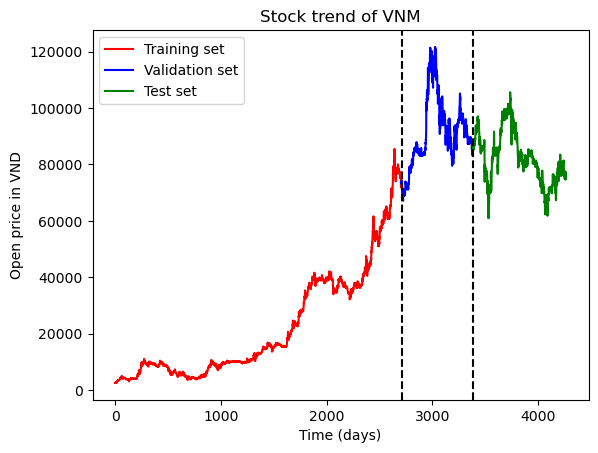

In [9]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of VNM")
plt.xlabel('Time (days)')
plt.ylabel('Open price in VND')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [10]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [11]:
### Create and train the model

# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

2023-04-12 22:46:18.743838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
6/6 [==============================] - 2s 121ms/step - loss: 1.2275 - mse: 1.2275 - val_loss: 0.3457 - val_mse: 0.3457
Epoch 2/5
6/6 [==============================] - 0s 60ms/step - loss: 0.2523 - mse: 0.2523 - val_loss: 0.2284 - val_mse: 0.2284
Epoch 3/5
6/6 [==============================] - 0s 65ms/step - loss: 0.1566 - mse: 0.1566 - val_loss: 0.1504 - val_mse: 0.1504
Epoch 4/5
6/6 [==============================] - 0s 67ms/step - loss: 0.1339 - mse: 0.1339 - val_loss: 0.1394 - val_mse: 0.1394
Epoch 5/5
6/6 [==============================] - 0s 57ms/step - loss: 0.1176 - mse: 0.1176 - val_loss: 0.1187 - val_mse: 0.1187


In [12]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [13]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

27/27 [==============================] - 0s 3ms/step
MSE on the test set:  0.12925701865630976


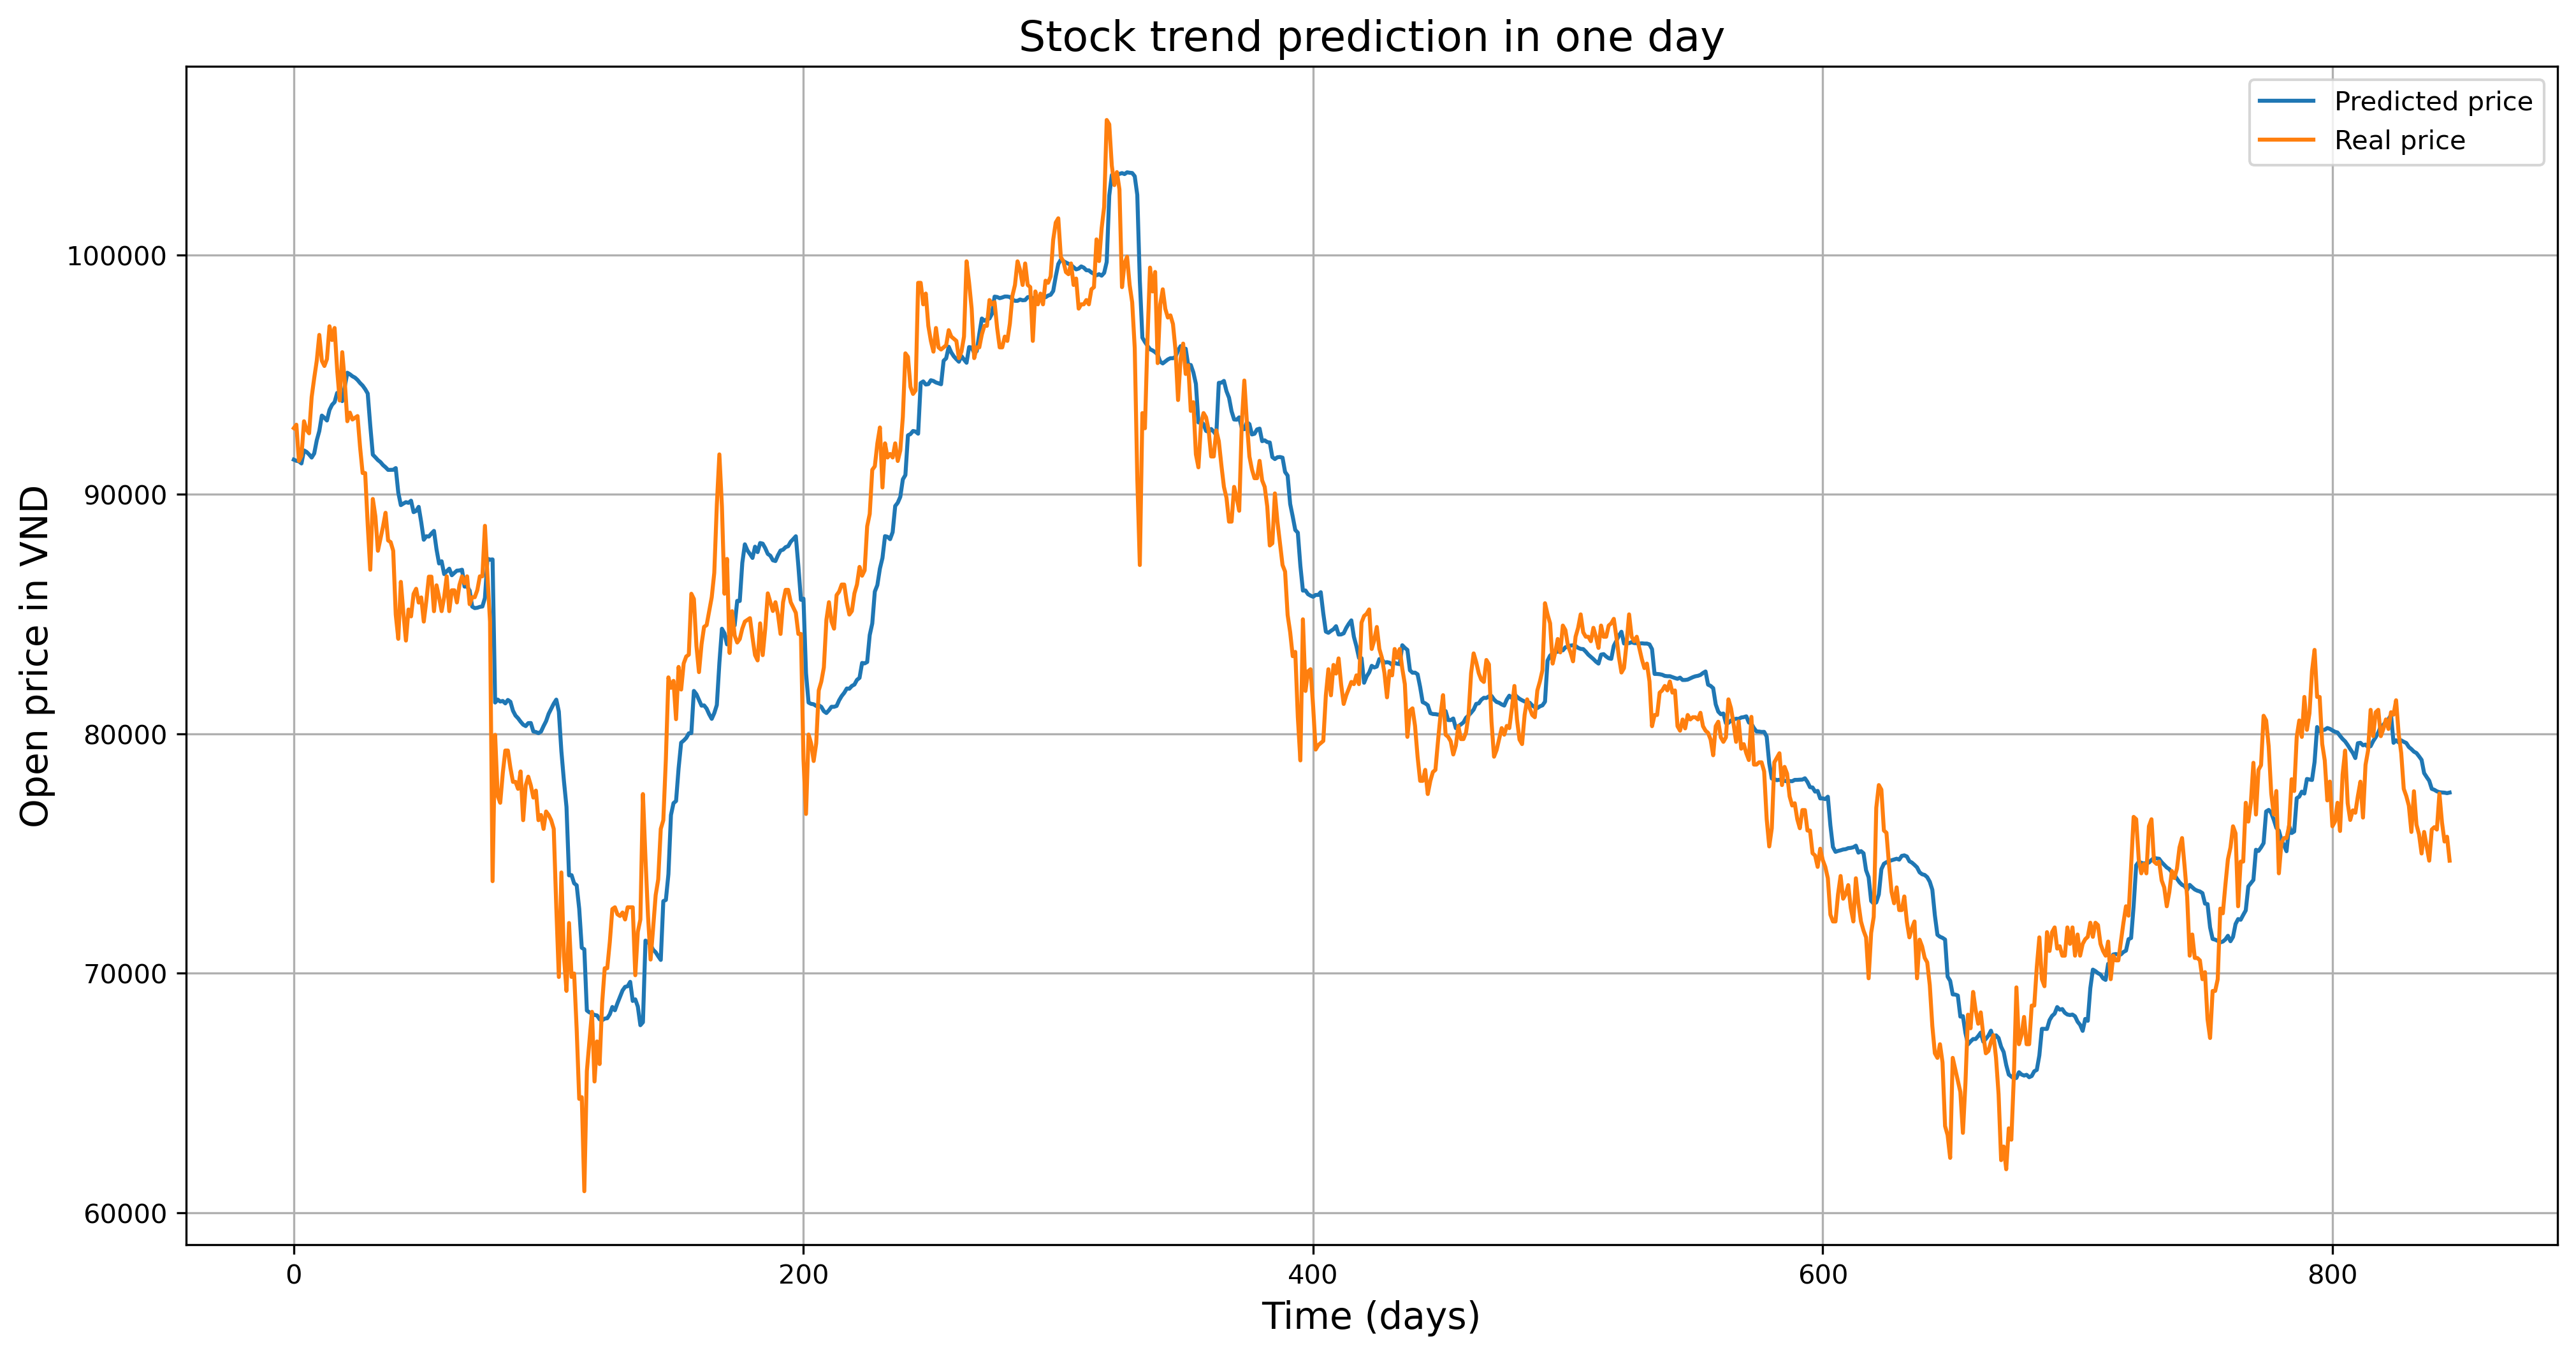

In [14]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in VND', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()